# Обработка признаков (часть 2)

#### Задание:

Выбрать один или несколько наборов данных (датасетов) для решения следующих задач. Каждая задача может быть решена на отдельном датасете, или несколько задач могут быть решены на одном датасете. Просьба не использовать датасет, на котором данная задача решалась в лекции.

Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:

- масштабирование признаков (не менее чем тремя способами);
- обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
- обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);
- отбор признаков:
1. один метод из группы методов фильтрации (filter methods);
2. один метод из группы методов обертывания (wrapper methods);
3. один метод из группы методов вложений (embedded methods).

In [5]:
from enum import Enum
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
data = pd.read_csv('./ds_salaries.csv', sep=",")
print(data.shape)
data.head()

(3755, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Масштабирование признаков

In [7]:
data_to_scale = data[['salary', 'salary_in_usd']]
data_to_scale.describe()

,salary,salary_in_usd
count,3755.000,3755.000
mean,190695.572,137570.390
std,671676.501,63055.625
min,6000.000,5132.000
25%,100000.000,95000.000
50%,138000.000,135000.000
75%,180000.000,175000.000
max,30400000.000,450000.000


На основе Z-оценки

In [8]:
scaler1 = StandardScaler()
data_scaled1 = pd.DataFrame(scaler1.fit_transform(data_to_scale), columns=data_to_scale.columns)
data_scaled1.describe()

,salary,salary_in_usd
count,3755.000,3755.000
mean,-0.000,0.000
std,1.000,1.000
min,-0.275,-2.101
25%,-0.135,-0.675
50%,-0.078,-0.041
75%,-0.016,0.594
max,44.982,4.955


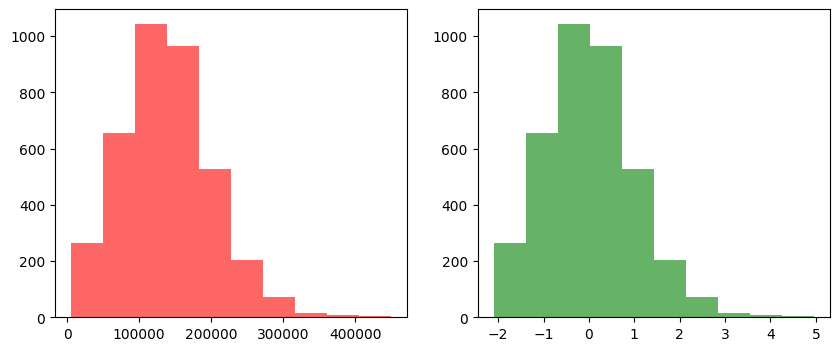

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(data["salary_in_usd"], color="r", alpha=0.6)
axs[1].hist(data_scaled1["salary_in_usd"], color="g", alpha=0.6)
plt.show()

MinMax-масштабирование

In [10]:
scaler2 = MinMaxScaler()
data_scaled2 = pd.DataFrame(scaler2.fit_transform(data_to_scale), columns=data_to_scale.columns)
data_scaled2.describe()

,salary,salary_in_usd
count,3755.000,3755.000
mean,0.006,0.298
std,0.022,0.142
min,0.000,0.000
25%,0.003,0.202
50%,0.004,0.292
75%,0.006,0.382
max,1.000,1.000


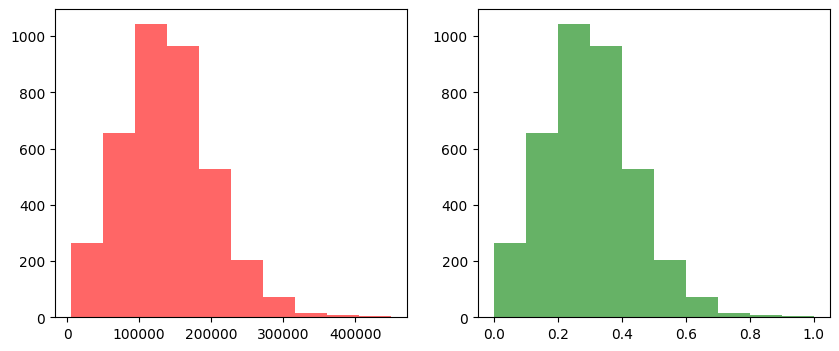

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(data["salary_in_usd"], color="r", alpha=0.6)
axs[1].hist(data_scaled2["salary_in_usd"], color="g", alpha=0.6)
plt.show()

По максимальному значению

In [12]:
scaler3 = RobustScaler()
data_scaled3 = pd.DataFrame(scaler3.fit_transform(data_to_scale), columns=data_to_scale.columns)
data_scaled3.describe()

,salary,salary_in_usd
count,3755.000,3755.000
mean,0.659,0.032
std,8.396,0.788
min,-1.650,-1.623
25%,-0.475,-0.500
50%,0.000,0.000
75%,0.525,0.500
max,378.275,3.938


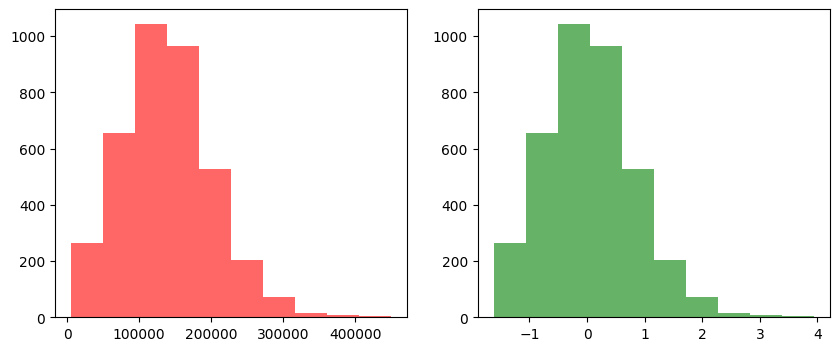

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(data["salary_in_usd"], color="r", alpha=0.6)
axs[1].hist(data_scaled3["salary_in_usd"], color="g", alpha=0.6)
plt.show()

### Обработка выбросов

In [14]:
# Тип вычисления верхней и нижней границы выбросов
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3
    
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df.mean() - (K1 * df.std())
        upper_boundary = df.mean() + (K1 * df.std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df.quantile(0.05)
        upper_boundary = df.quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df.quantile(0.75) - df.quantile(0.25)
        lower_boundary = df.quantile(0.25) - (K2 * IQR)
        upper_boundary = df.quantile(0.75) + (K2 * IQR)

    return lower_boundary, upper_boundary  

In [15]:
data2 = data_scaled3.copy()

Замена выбросов

OutlierBoundaryType.SIGMA


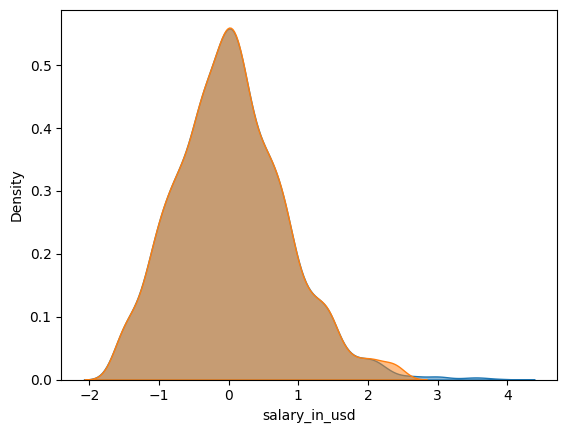

OutlierBoundaryType.QUANTILE


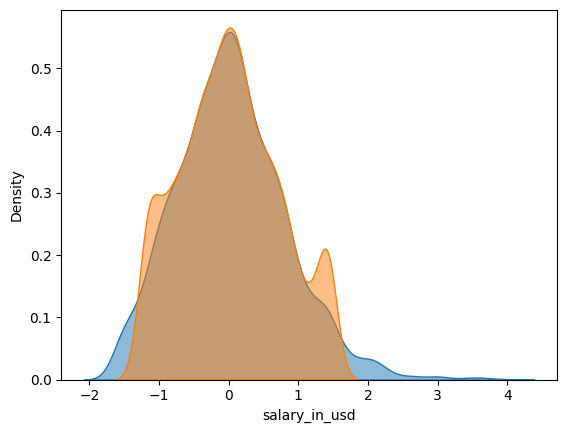

OutlierBoundaryType.IRQ


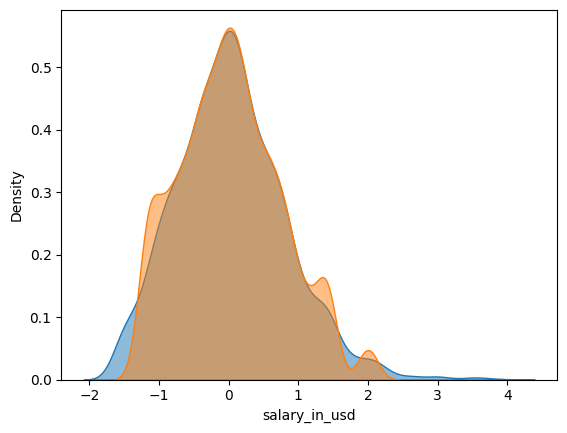

In [16]:
for obt in OutlierBoundaryType:
    lower_boundary, upper_boundary = get_outlier_boundaries(data_scaled3['salary_in_usd'], obt)
    data2['salary_in_usd'] = np.where(data_scaled3['salary_in_usd'] > upper_boundary, upper_boundary,
        np.where(data2['salary_in_usd'] < lower_boundary, lower_boundary,
        data2['salary_in_usd']))
    sns.kdeplot(data_scaled3['salary_in_usd'], alpha=0.5, fill=True)
    sns.kdeplot(data2['salary_in_usd'], alpha=0.5, fill=True)
    print(obt)
    plt.show()

Удаление выбросов

OutlierBoundaryType.SIGMA


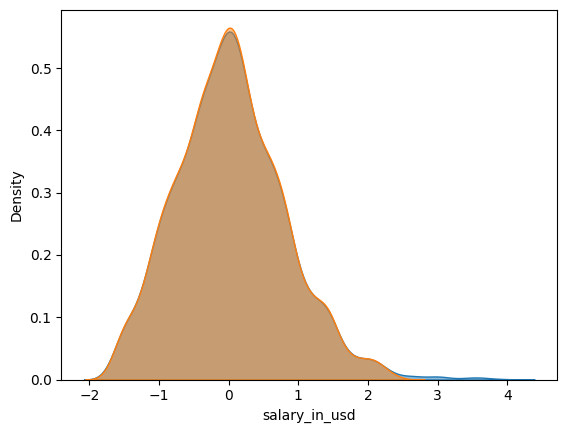

OutlierBoundaryType.QUANTILE


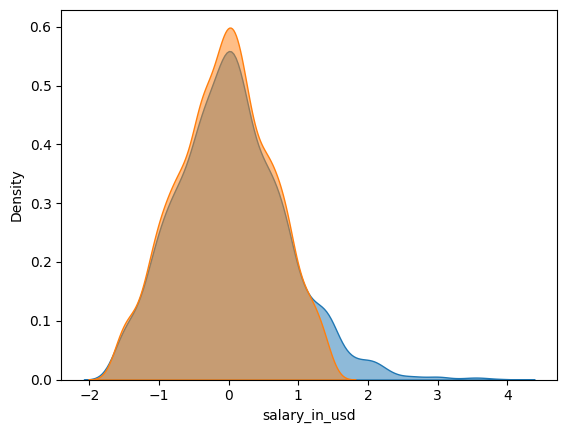

OutlierBoundaryType.IRQ


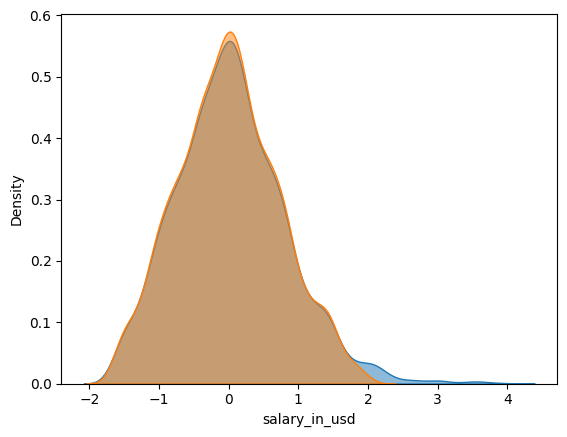

In [17]:
for obt in OutlierBoundaryType:
    lower_boundary, upper_boundary = get_outlier_boundaries(data_scaled3['salary_in_usd'], obt)
    temp_df = np.where(data_scaled3['salary_in_usd'] > upper_boundary, True,
        np.where(data2['salary_in_usd'] < lower_boundary, True, False))
    data_trimmed = data_scaled3.loc[~(temp_df), ]
    sns.kdeplot(data_scaled3['salary_in_usd'], alpha=0.5, fill=True)
    sns.kdeplot(data_trimmed['salary_in_usd'], alpha=0.5, fill=True)
    print(obt)
    plt.show()

### Отбор признаков

Удаление коррелирующих признаков

In [18]:
wine = load_wine()
data = pd.DataFrame(data=wine['data'], columns= wine['feature_names'])
y = wine['target']

data['alcohol_2'] = data['alcohol'] + np.random.rand(len(data['alcohol']))
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,alcohol_2
0,14.230,1.710,2.430,15.600,127.000,2.800,3.060,0.280,2.290,5.640,1.040,3.920,1065.000,15.013
1,13.200,1.780,2.140,11.200,100.000,2.650,2.760,0.260,1.280,4.380,1.050,3.400,1050.000,13.402
2,13.160,2.360,2.670,18.600,101.000,2.800,3.240,0.300,2.810,5.680,1.030,3.170,1185.000,13.821
3,14.370,1.950,2.500,16.800,113.000,3.850,3.490,0.240,2.180,7.800,0.860,3.450,1480.000,15.190
4,13.240,2.590,2.870,21.000,118.000,2.800,2.690,0.390,1.820,4.320,1.040,2.930,735.000,14.073


In [19]:
def make_corr_df(data):
    cr = data.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.80]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [20]:
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [21]:
corr_df = make_corr_df(data)
print(corr_df)
corr_groups(corr_df)

              f1             f2  corr
0        alcohol      alcohol_2 0.948
1      alcohol_2        alcohol 0.948
2  total_phenols     flavanoids 0.865
3     flavanoids  total_phenols 0.865


[['alcohol_2', 'alcohol'], ['flavanoids', 'total_phenols']]

Метод обёртывания

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
efs1 = EFS(knn, 
           min_features=2,
           max_features=4,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(data, y)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset:', efs1.best_feature_names_)

Features: 1456/1456

Best accuracy score: 0.95
Best subset: ('total_phenols', 'flavanoids', 'color_intensity', 'alcohol_2')


Метод вложений

In [23]:
e_lr1 = LogisticRegression(C=1000, solver='liblinear', penalty='l1', max_iter=500, random_state=1)
e_lr1.fit(data, y)
e_lr1.coef_

array([[ 5.51806241e-01,  3.73264975e+00,  1.46387036e+01,
        -1.93986865e+00,  2.95108929e-02, -2.17584912e-01,
         7.51991146e+00, -1.30397396e+00, -4.95558022e+00,
        -1.45550202e+00, -7.55406098e+00,  2.49654291e+00,
         5.05703088e-02,  1.08686355e+00],
       [-7.42665611e-01, -3.11149834e+00, -1.51464594e+01,
         1.35547948e+00, -4.90095529e-02,  1.06333607e+00,
         2.41992894e+00,  1.20488124e+01,  3.15378813e+00,
        -5.78149253e+00,  2.05679581e+01, -3.42118420e+00,
        -3.76242690e-02, -2.42421518e-01],
       [ 2.86740402e-01,  1.85051001e+00,  1.97144302e+00,
         1.80579250e-01,  3.96596709e-02,  8.59425175e-02,
        -9.87923991e+00, -1.07598787e+01, -3.71692556e+00,
         2.33251272e+00, -1.00425195e+01, -5.93590355e+00,
         6.22073607e-03,  2.02578573e-01]])

In [24]:
sel_e_lr1 = SelectFromModel(e_lr1)
sel_e_lr1.fit(data, y)
sel_e_lr1.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

### Обработка нестандартного признака

In [27]:
data = pd.read_csv('./sakura_first_bloom_dates.csv', sep=",")
print(data.shape)
data.head()

(102, 72)


,Site Name,Currently Being Observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2013,2014,2015,2016,2017,2018,2019,2020,30 Year Average 1981-2010,Notes
0,Wakkanai,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,1959-05-03,1960-05-19,...,2013-05-26,2014-05-11,2015-05-03,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,5 14,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,1959-05-08,1960-05-13,...,2013-05-18,2014-05-02,2015-04-27,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,5 5,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaN,NaN,1959-05-03,NaN,...,2013-05-25,2014-05-07,2015-04-30,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,5 11,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaN,1959-05-05,1960-05-05,...,2013-05-13,2014-04-29,2015-04-22,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,5 3,NaN


In [28]:
data_revamped = data.copy()
for year in range(1953, 2021):
    data_revamped[str(year)] = pd.to_datetime(data[str(year)])
data_revamped.dtypes


Site Name                            object
Currently Being Observed               bool
1953                         datetime64[ns]
1954                         datetime64[ns]
1955                         datetime64[ns]
                                  ...      
2018                         datetime64[ns]
2019                         datetime64[ns]
2020                         datetime64[ns]
30 Year Average 1981-2010            object
Notes                                object
Length: 72, dtype: object

In [29]:
data_revamped.head()

,Site Name,Currently Being Observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2013,2014,2015,2016,2017,2018,2019,2020,30 Year Average 1981-2010,Notes
0,Wakkanai,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,1959-05-03,1960-05-19,...,2013-05-26,2014-05-11,2015-05-03,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,5 14,Sargent cherry (Prunus sargentii)
1,Rumoi,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,1959-05-08,1960-05-13,...,2013-05-18,2014-05-02,2015-04-27,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,5 5,Sargent cherry (Prunus sargentii)
3,Abashiri,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaT,NaT,1959-05-03,NaT,...,2013-05-25,2014-05-07,2015-04-30,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,5 11,Sargent cherry (Prunus sargentii)
4,Sapporo,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaT,1959-05-05,1960-05-05,...,2013-05-13,2014-04-29,2015-04-22,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,5 3,NaN


In [30]:
data_revamped['last_day'] = data_revamped['2020'].dt.day
data_revamped['last_month'] = data_revamped['2020'].dt.month
data_revamped['last_year'] = data_revamped['2020'].dt.year
data_revamped['last_week'] = data_revamped['2020'].dt.isocalendar().week
data_revamped.head()

,Site Name,Currently Being Observed,1953,1954,1955,1956,1957,1958,1959,1960,...,2017,2018,2019,2020,30 Year Average 1981-2010,Notes,last_day,last_month,last_year,last_week
0,Wakkanai,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,1959-05-03,1960-05-19,...,2017-05-09,2018-05-12,2019-05-07,2020-05-10,5 14,Sargent cherry (Prunus sargentii),10.000,5.000,2020.000,19
1,Rumoi,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,NaT,NaT,...,NaT,NaT,NaT,NaT,-,Sargent cherry (Prunus sargentii),NaN,NaN,NaN,<NA>
2,Asahikawa,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,1959-05-08,1960-05-13,...,2017-05-03,2018-04-30,2019-05-01,2020-05-03,5 5,Sargent cherry (Prunus sargentii),3.000,5.000,2020.000,18
3,Abashiri,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaT,NaT,1959-05-03,NaT,...,2017-05-05,2018-05-02,2019-05-05,2020-05-07,5 11,Sargent cherry (Prunus sargentii),7.000,5.000,2020.000,19
4,Sapporo,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaT,1959-05-05,1960-05-05,...,2017-04-28,2018-04-26,2019-04-24,2020-04-30,5 3,NaN,30.000,4.000,2020.000,18


In [31]:
new_features = ['last_day', 'last_month', 'last_year', 'last_week']
newScaler = RobustScaler()
data_revamped[new_features] = pd.DataFrame(newScaler.fit_transform(data_revamped[new_features]), columns=new_features)
data_revamped.describe()

,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,...,2015,2016,2017,2018,2019,2020,last_day,last_month,last_year,last_week
count,79,81,82,84,83,83,86,85,86,88,...,58,58,58,58,58,58,58.000,58.000,58.000,58.000
mean,1953-04-07 15:11:23.544303808,1954-04-05 18:04:26.666666688,1955-04-03 05:33:39.512195136,1956-04-08 02:00:00,1957-04-10 21:06:30.361445760,1958-04-07 22:50:36.144578304,1959-03-31 21:29:18.139534912,1960-04-05 20:36:42.352941184,1961-04-08 07:48:50.232558144,1962-04-08 15:49:05.454545440,...,2015-03-26 02:28:57.931034368,2016-03-27 07:26:53.793103360,2017-04-01 01:39:18.620689664,2018-03-24 04:57:55.862068992,2019-03-26 23:35:10.344827648,2020-03-25 22:20:41.379310336,-0.326,0.299,0.000,-0.020
min,1953-01-09 00:00:00,1954-01-21 00:00:00,1955-01-07 00:00:00,1956-01-05 00:00:00,1957-01-14 00:00:00,1958-01-10 00:00:00,1959-01-12 00:00:00,1960-01-23 00:00:00,1961-01-20 00:00:00,1962-01-26 00:00:00,...,2015-01-06 00:00:00,2016-01-18 00:00:00,2017-01-14 00:00:00,2018-01-07 00:00:00,2019-01-07 00:00:00,2020-01-06 00:00:00,-1.955,-2.667,0.000,-6.286
25%,1953-03-28 12:00:00,1954-03-28 00:00:00,1955-03-25 06:00:00,1956-03-29 00:00:00,1957-04-05 00:00:00,1958-03-28 00:00:00,1959-03-23 00:00:00,1960-03-26 00:00:00,1961-03-31 00:00:00,1962-04-02 00:00:00,...,2015-03-23 00:00:00,2016-03-23 00:00:00,2017-03-30 00:00:00,2018-03-19 00:00:00,2019-03-22 06:00:00,2020-03-22 00:00:00,-0.773,0.000,0.000,-0.571
50%,1953-04-04 00:00:00,1954-03-31 00:00:00,1955-03-30 00:00:00,1956-04-05 00:00:00,1957-04-08 00:00:00,1958-04-04 00:00:00,1959-03-27 12:00:00,1960-03-30 00:00:00,1961-04-04 00:00:00,1962-04-06 00:00:00,...,2015-03-27 12:00:00,2016-03-26 12:00:00,2017-04-02 00:00:00,2018-03-23 12:00:00,2019-03-27 00:00:00,2020-03-25 00:00:00,0.000,0.000,0.000,0.000
75%,1953-04-15 12:00:00,1954-04-07 00:00:00,1955-04-10 00:00:00,1956-04-16 06:00:00,1957-04-17 00:00:00,1958-04-13 00:00:00,1959-04-07 18:00:00,1960-04-13 00:00:00,1961-04-16 18:00:00,1962-04-16 00:00:00,...,2015-04-02 00:00:00,2016-04-01 00:00:00,2017-04-07 18:00:00,2018-03-29 18:00:00,2019-04-05 00:00:00,2020-03-31 00:00:00,0.227,1.000,0.000,0.429
max,1953-05-24 00:00:00,1954-05-17 00:00:00,1955-05-19 00:00:00,1956-05-13 00:00:00,1957-05-18 00:00:00,1958-05-23 00:00:00,1959-05-08 00:00:00,1960-05-25 00:00:00,1961-05-18 00:00:00,1962-05-15 00:00:00,...,2015-05-06 00:00:00,2016-05-13 00:00:00,2017-05-14 00:00:00,2018-05-12 00:00:00,2019-05-09 00:00:00,2020-05-10 00:00:00,0.682,2.667,0.000,3.429
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.797,1.173,0.000,1.900
